# Loading the data, splitting into training and test set

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
#from utils import plot_tree_boundaries

features = ['age','acutephysiologyscore']
outcome = 'actualhospitalmortality'

data = pd.read_csv("../Decision_Trees_Training_UoSheffield/eicu_cohort_trees.csv")

# ---- Age - replace all values >89 with 91.5
data.replace({'age':'> 89'},91.5, inplace=True)
data['age'] = data['age'].astype(int) 
actualhospitalmortality = {'ALIVE':0, 'EXPIRED':1}
data.actualhospitalmortality = [actualhospitalmortality[item] for item in data.actualhospitalmortality]

x = data[features]# 2 feautures
y = data[outcome]#1 outcome

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=42)

# Gradient Boosting
Next, we move on to gradient boosting. Gradient boosting elegantly combines concepts from the previous methods. As a “boosting” method, gradient boosting involves iteratively building trees, aiming to improve upon misclassifications of the previous tree. Gradient boosting also borrows the concept of sub-sampling the variables (just like Random Forests), which can help to prevent overfitting.

While it is too much to express in this tutorial, the biggest innovation in gradient boosting is that it provides a unifying mathematical framework for boosting models. The approach explicitly casts the problem of building a tree as an optimization problem, defining mathematical functions for how well a tree is performing (which we had before) and how complex a tree is. In this light, one can actually treat AdaBoost as a “special case” of gradient boosting, where the loss function is chosen to be the exponential loss.

Again, our data cannot contain missing data. Let’s fix that and build a gradient boosting model.

In [3]:
# Fill missing data with -1
data_no_nans = data.fillna(-1)

x = data_no_nans[features]
y = data_no_nans[outcome]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, random_state =  42)

**Task:** Use [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) to train a gradient boosting classifier with 10 estimators.

<Figure size 600x600 with 0 Axes>

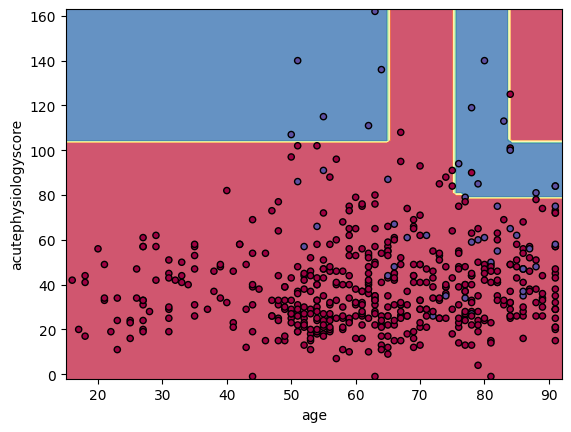

In [4]:
#Binary classification is a special case where only a single regression tree is induced.
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
%matplotlib inline

np.random.seed(321)
model = GradientBoostingClassifier(n_estimators=10,
                                   random_state=2)
model = model.fit(x_train, y_train)

plt.figure(figsize=(6,6))
DecisionBoundaryDisplay.from_estimator(model, x_train, cmap=plt.cm.Spectral, 
                                       response_method="predict", alpha = 0.8)
plt.scatter(x['age'], x['acutephysiologyscore'], c=y, cmap=plt.cm.Spectral , s=20, edgecolor="k")
#plt.show()

# Model Evaluation
We’ve now learned the basics of the various tree methods and have visualized most of them; however, how do we actually know which one is the best predictive model? Let’s finish by comparing the performance of our models on our held-out test data. 
- Our goal, remember, is to predict whether or not a patient will survive their hospital stay using the patient’s age and acute physiology score computed on the first day of their ICU stay.

Firstly we begin by training the model for each of the techniques we have looked at so far (the step for defining training and test has been already done in the beginning of this notebook).


In [6]:
from sklearn import metrics, ensemble, tree

models = dict()
models['Decision Tree'] = tree.DecisionTreeClassifier(criterion='entropy', splitter='best').fit(x_train, y_train)
models['Gradient Boosting'] = ensemble.GradientBoostingClassifier(n_estimators=10).fit(x_train, y_train)
models['Random Forest'] = ensemble.RandomForestClassifier(n_estimators=10).fit(x_train, y_train)
models['Bagging'] =  ensemble.BaggingClassifier(n_estimators=10).fit(x_train, y_train)
models['AdaBoost'] =  ensemble.AdaBoostClassifier(n_estimators=10).fit(x_train, y_train)

We now have a model for each of the techniques we have looked at. There are a number of different metrics we can use to measure the performance of our model, depending on what we want to measure. The most basic is **accuracy** - on the test set, how many predictions does our model get correct?

In [7]:
print('Accuracy\tModel')
for current_model in models:    
    predicted_proba = models[current_model].predict_proba(x_test)[:, 1]
    predictions = models[current_model].predict(x_test)
    
    score = metrics.accuracy_score(y_test, predictions)
    print('{:0.3f}\t{}'.format(score, current_model))

Accuracy	Model
0.876	Decision Tree
0.938	Gradient Boosting
0.907	Random Forest
0.907	Bagging
0.925	AdaBoost


As you might expect (but is, crucially, not always the case!), the more advanced gradient boosting technique achieves the best performance.

**Question:** What is a possible issue with relying on accuracy as a performance metric?

Accuacy is not always a suitable performance metric, especially when our data is unbalanced (i.e. there are many more samples in one class than the other).

Another issue with accuracy is that it only measures performance at a single decision threshold. 

To inspect how well our models perform at different thresholds, we can plot the Receiver Operating Characteristic curve. 
- This curve plots the false positive rate (x-axis) against the true positive rate (y-axis) at different decision thresholds. 
- Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives (and vice-versa when increasing the threshold). 
- We can summarise this curve by calculating the area under the curve (AUROC, for Area Under the Receiver Operating Characteristic curve).

**Task:** Search for the correct functions in [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) to display the ROC curve, and calculate the AUROC for each model.

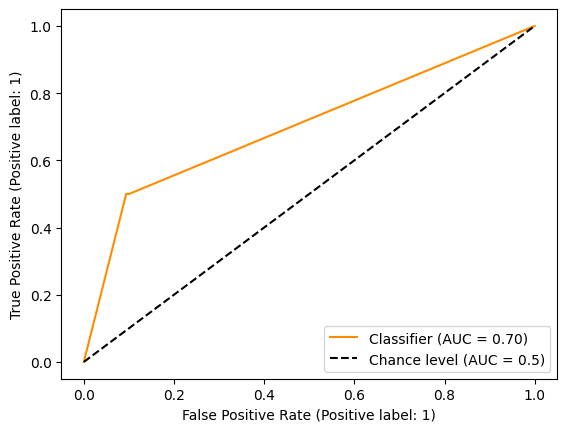

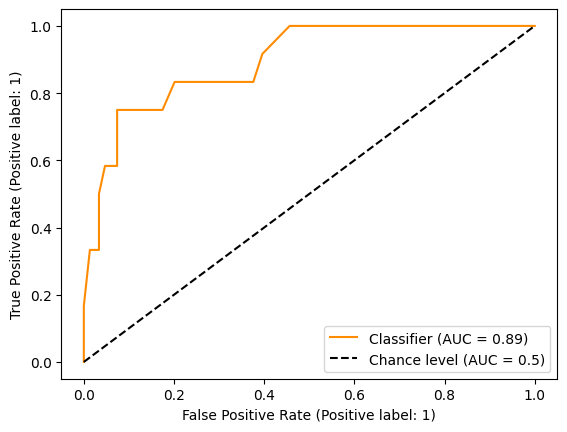

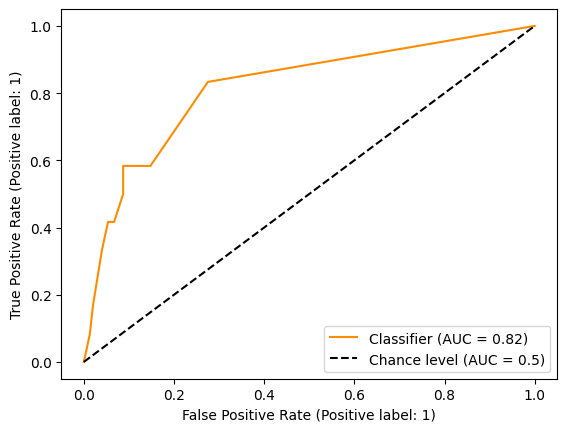

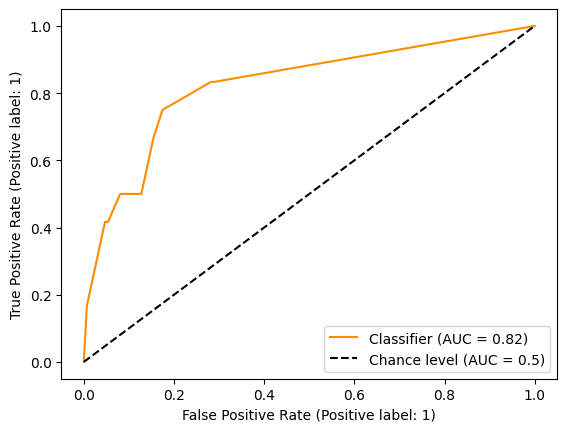

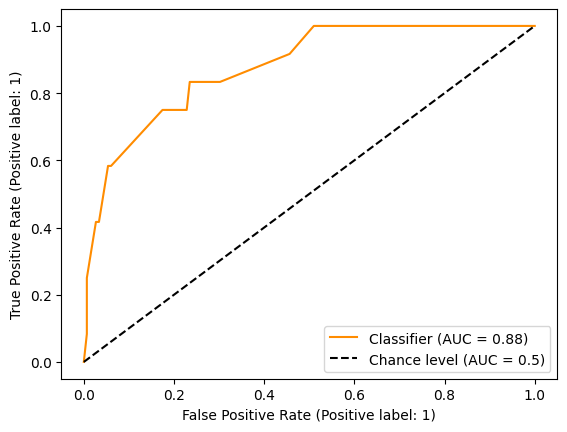

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

#ax = plt.subplot()

for current_model in models:    
   # Display the ROC curve
   predicted_proba = models[current_model].predict_proba(x_test)[:, 1]
   predictions = models[current_model].predict(x_test)
    
   RocCurveDisplay.from_predictions(y_test, 
                                     predicted_proba,
                                    color="darkorange",
                                    plot_chance_level=True)
   
   
   

In [9]:
#roc_auc_score(y_test, current_model.predicted_proba)
   
print('AUROC\tModel')
for current_model in models:    
   # Calculate and print AUROC
   predicted_proba = models[current_model].predict_proba(x_test)[:, 1]
   predictions = models[current_model].predict(x_test)
   
   AUROC = roc_auc_score(y_test, predicted_proba)
   print('{:0.3f}\t{}'.format(AUROC, current_model))

AUROC	Model
0.701	Decision Tree
0.894	Gradient Boosting
0.816	Random Forest
0.824	Bagging
0.878	AdaBoost


- Gradient Boosting seems to perform better than the rest models, following by AdaBoost

## Precision and Recall

A binary classification model can fail in one of two ways: false negatives (a predictive model misses a positive sample) and false positives (a predictive model incorrectly labels a negative sample as positive). 
- In some cases, we may prefer our model to make one type of error over the other. 
- For example, in our mortality prediction scenario, it may be desireable to make fewer false negative classifications (as this means we will miss patients at risk of critical deterioration) at the expense of making more false positive errors. Conversely, when doing email spam detection, you likely want to prioritize minimizing false positives (even if that results in a significant increase of false negatives).

This is where metrics such as precision and recall come in. Precision measures: What proportion of positive identifications was actually correct?

**Question:** Can you come up with a possible formula for precision?

Recall, on the other hand, measures proportion of actual positives was identified correctly?

**Question:** Can you come up with a possible formula for recall?

Let's calculate the precision and recall of our models.

**Task:** Search for the correct functions in [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) to calculate the precision and recall for each model.

In [10]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print('Precision\tRecall\tModel')
print('--------------------------')
for current_model in models:    
    predictions = models[current_model].predict(x_test)
    # Calculate and print the precision and recall
    #, average='macro'
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    print(precision, "|", recall, "|", current_model)
    #print('{:0.4f}\t{}'.format(precision, recall, current_model))
    #precision shows the True positive / True positives and False positives

Precision	Recall	Model
--------------------------
0.3 | 0.5 | Decision Tree
0.6666666666666666 | 0.3333333333333333 | Gradient Boosting
0.38461538461538464 | 0.4166666666666667 | Random Forest
0.38461538461538464 | 0.4166666666666667 | Bagging
0.5 | 0.4166666666666667 | AdaBoost


We can see that all of our models have low precision and recall scores, despite having high AUROC and accuracy. Let's take a look at the Gradient Boosting results in a bit more detail to see what these results are telling us.

**Question:** The gradient boosting model has a precision of 0.6667 - what does this mean in terms of the positively classified predictions?

**Question:** The gradient boosting model has a recall of 0.333 - what does this mean in terms of our predictions?

As our model has a precision of 0.6667, this means that when it predicts a patient will not survive their hospital stay, it is correct two thirds of the time. With a recall of 0.3333, it means we correctly 33% of patients who do not survive their stay.

Precision and recall are opposing metrics - by increasing the decision threshold we will increase precision while reducing recall, and vice-versa. We can visualise this by plotting a precision recall curve.

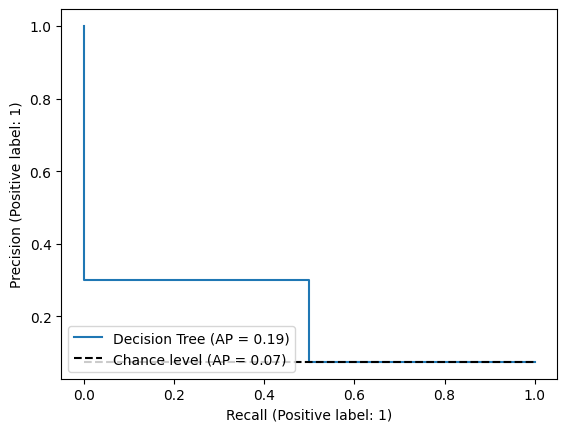

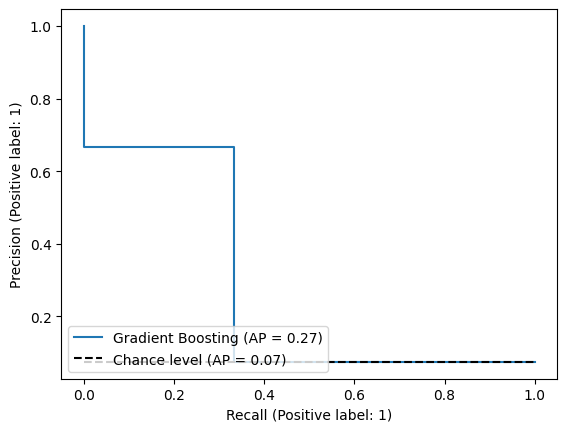

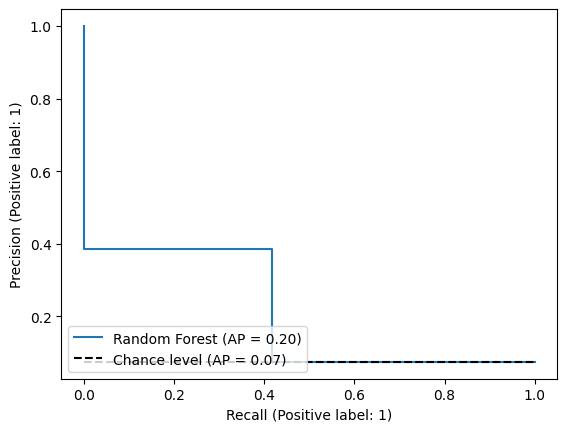

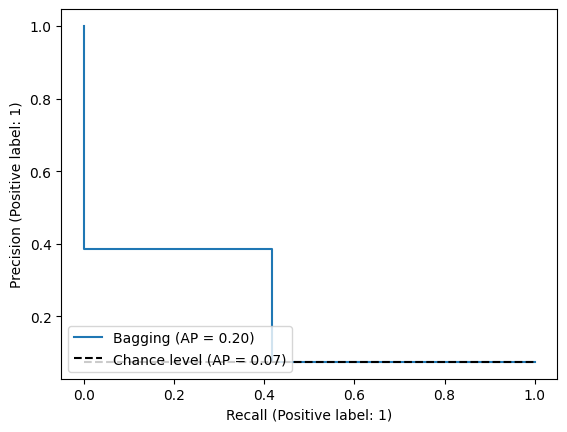

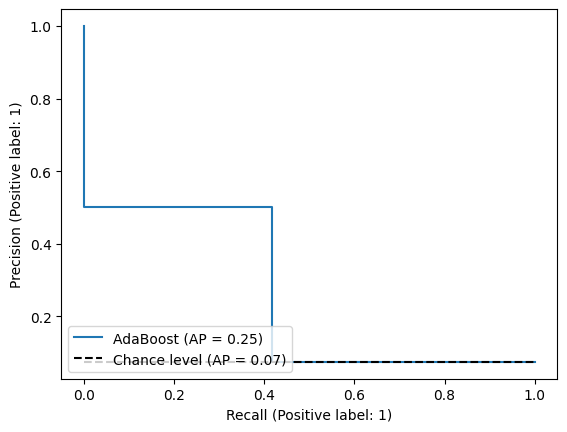

In [11]:
#ax = plt.subplot()
from sklearn.metrics import PrecisionRecallDisplay
for current_model in models:
    predictions = models[current_model].predict(x_test)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    # Show the precision-recall curve
    display = PrecisionRecallDisplay.from_predictions(y_test,
                                                      predictions,
                                                      name = current_model,
                                                      plot_chance_level=True)


- The graphs don't seem as good as they should be because in the current dataset we have only 2 features inserted that might lead to this performance

The F-score measures this trade-off between precision and recall, and is often used to give a general idea of model performance - especially when the data is imbalanced. Typically we use the F1 score, which is the harmonic mean of precision and recall, but this can be changed to the F-β score, which weights precision by β.

**Question:** What is the formula for the F-β score?

- F1 = 2 * (precision * recall) / (precision + recall)

Let's calculate the F1 score of our models.

In [12]:
from sklearn.metrics import f1_score
print('F1\tModel')
for current_model in models:
    # Calculate the F1 score for the model
    predictions = models[current_model].predict(x_test)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1Scores = f1_score(y_test,
                       predictions)
print('{:0.3f}\t{}'.format(f1Scores, current_model))



F1	Model
0.455	AdaBoost


With such low precision and recall values, our models may not be very useful in practice. There are multiple possible explanations for this: our task might be difficult, our models might not be powerful enough and so on. One notable point is that our data is imbalanced, and we have (so far) only used two features (age and acute physiology score) in our models.

**Question:** What proportion of our data is classified as a positive class (i.e. how many patients do not survive their hospital stay)?

Finally we will look at using different Python libraries to create more complex models that incorporate all available features in the dataset.

# LightGBM and xgboost

In all of our previous workbooks, we've focused on creating decision trees that use only two features - `age` and `acutephysiologyscore`. While this made it easier to understand how each of the techniques we used results in different models, as we saw in above it doesn't necessarily provide us with the best quality model.

Furthermore, so far we've focused on using the `sklearn` library to train our models. Whilst this library is extremely useful - and in many cases is able to create high-performing models - it is always helpful to have other tools in our toolbox. [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html) is a framework for creating gradient boosted decision trees with a Python API. [xgboost](https://xgboost.readthedocs.io/en/stable/) is a similar library. Although they can both be used for the same end goal, they each have their own pros and cons. Refer also to [Kaggle-example](https://www.kaggle.com/code/tush32/hospital-mortality-predection-using-pycaret-and-ml , https://www.kaggle.com/code/laurencegesman/hospital-mortality-ml-data-analysis/notebook)

**Question:** What are the differences between LightGBM and xgboost? When might you want to use one over the other?

This is an open-ended workbook - the purpose is for you to choose one of either LightGBM or xgboost and use it to create the best performing model for mortality prediction on our dataset that you can. Be sure to use your chosen library's developer documentation to help you, and feel free to use any other resources that you wish; if you want to go the extra mile, perhaps look at methods for [data imputation](https://scikit-learn.org/stable/modules/impute.html), or techniques to handle [imbalanced data](https://imbalanced-learn.org/stable/). Use the techniques from Workbook 08 to evaluate your final models - and be sure to remember what we learned in Workbook 03 - we don't want our models to overfit!

**Tip:** If you want to install a new Python package, you can do so in a Jupyter Notebook code cell with the following command: `!pip install package-name`.

In [14]:
#!pip install xgboost-cpu

<Figure size 600x600 with 0 Axes>

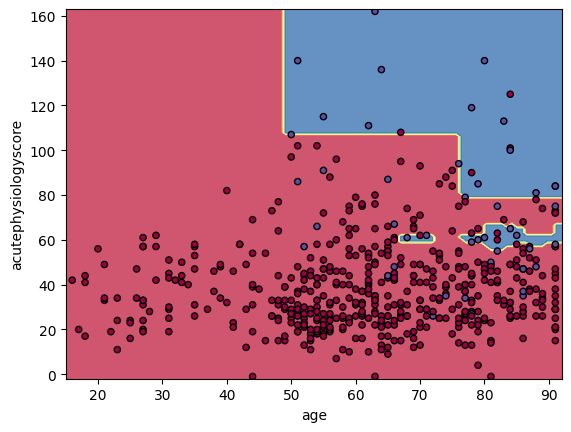

In [36]:
#Import XGboost cpu
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(n_estimators=10,
                                   random_state=42, max_depth=10)
model = model.fit(x_train, y_train)

plt.figure(figsize=(6,6))
DecisionBoundaryDisplay.from_estimator(model, x_train, cmap=plt.cm.Spectral, 
                                       response_method="predict", alpha = 0.8)
plt.scatter(x['age'], x['acutephysiologyscore'], c=y, cmap=plt.cm.Spectral , s=20, edgecolor="k")
#plt.show()

[LightGBM] [Info] Number of positive: 36, number of negative: 339
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 375, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.096000 -> initscore=-2.242481
[LightGBM] [Info] Start training from score -2.242481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<Figure size 600x600 with 0 Axes>

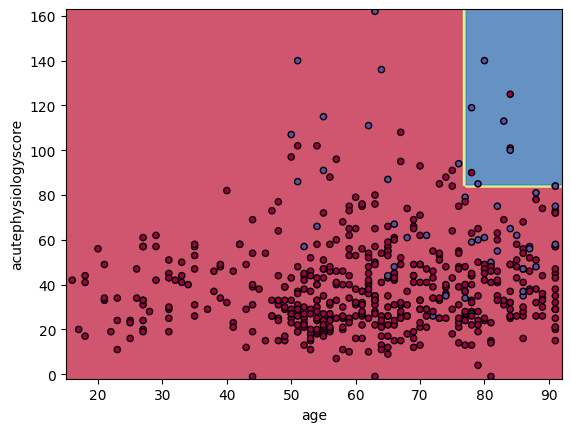

In [39]:
#Import Light GM
from lightgbm import LGBMClassifier

model = LGBMClassifier(n_estimators=10, max_depth=2)
model = model.fit(x_train, y_train)

plt.figure(figsize=(6,6))
DecisionBoundaryDisplay.from_estimator(model, x_train, cmap=plt.cm.Spectral, 
                                       response_method="predict", alpha = 0.8)
plt.scatter(x['age'], x['acutephysiologyscore'], c=y, cmap=plt.cm.Spectral , s=20, edgecolor="k")
#plt.show()

In [40]:
#Add the LGM and XGBoost in the models dict to compare them
models['LGM'] =  LGBMClassifier(n_estimators=10).fit(x_train, y_train)
models['XGBoost'] =  XGBClassifier(n_estimators=10).fit(x_train, y_train)

print('Accuracy\tModel')
for current_model in models:    
    predicted_proba = models[current_model].predict_proba(x_test)[:, 1]
    predictions = models[current_model].predict(x_test)
    
    score = metrics.accuracy_score(y_test, predictions)
    print('{:0.3f}\t{}'.format(score, current_model))

[LightGBM] [Info] Number of positive: 36, number of negative: 339
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 118
[LightGBM] [Info] Number of data points in the train set: 375, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.096000 -> initscore=-2.242481
[LightGBM] [Info] Start training from score -2.242481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

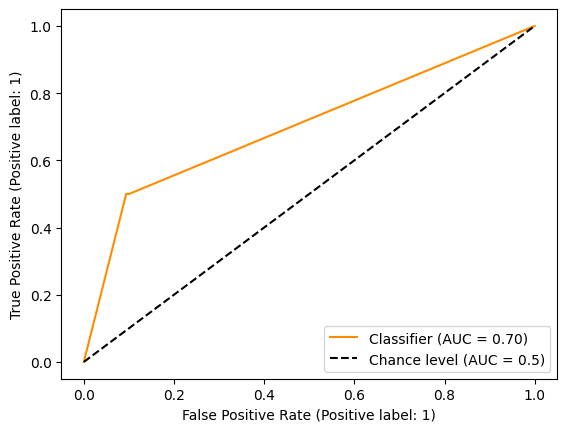

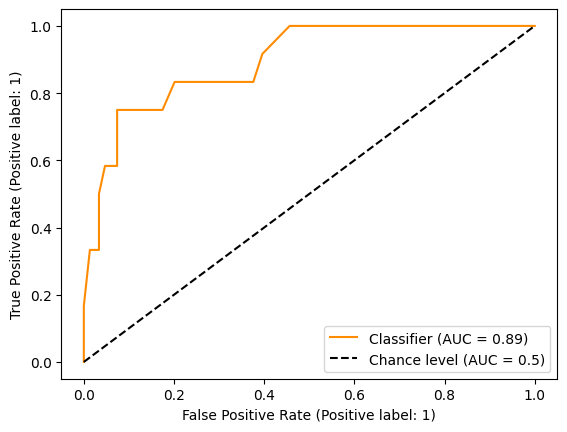

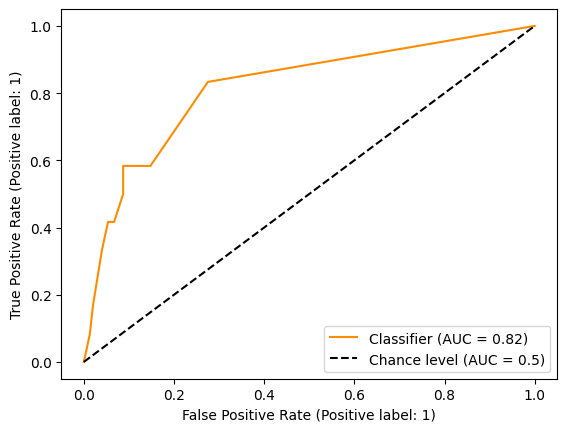

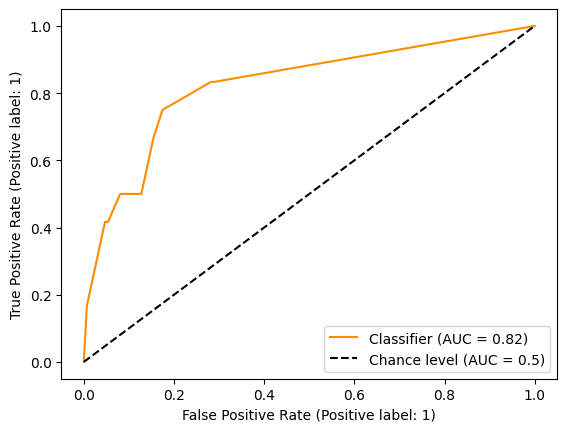

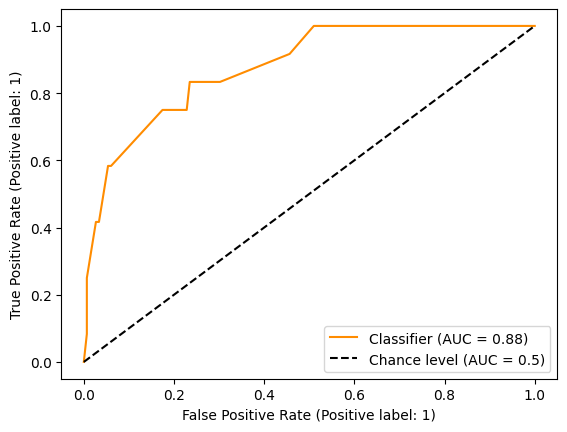

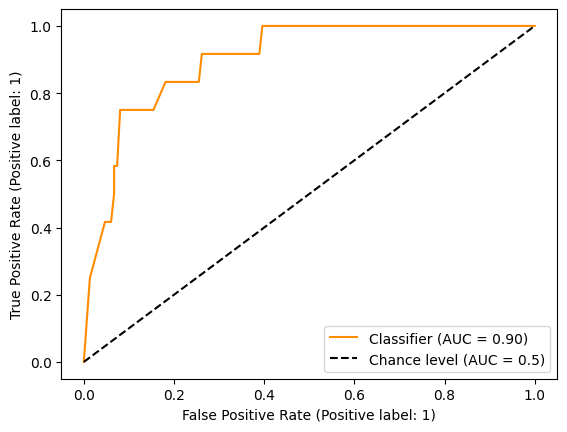

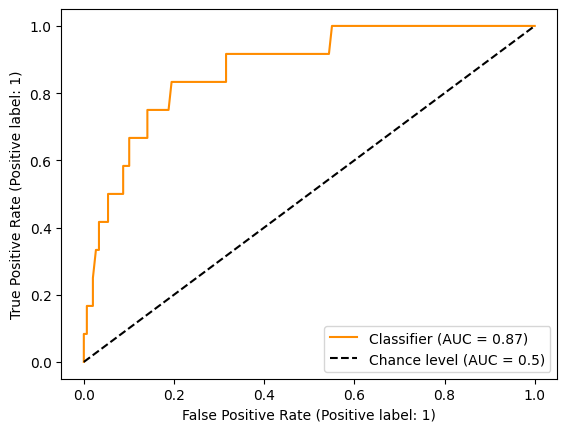

In [41]:
# Display the ROC curve
for current_model in models:    
   predicted_proba = models[current_model].predict_proba(x_test)[:, 1]
   predictions = models[current_model].predict(x_test)
    
   RocCurveDisplay.from_predictions(y_test, 
                                     predicted_proba,
                                    color="darkorange",
                                    plot_chance_level=True)

/home/conmec/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


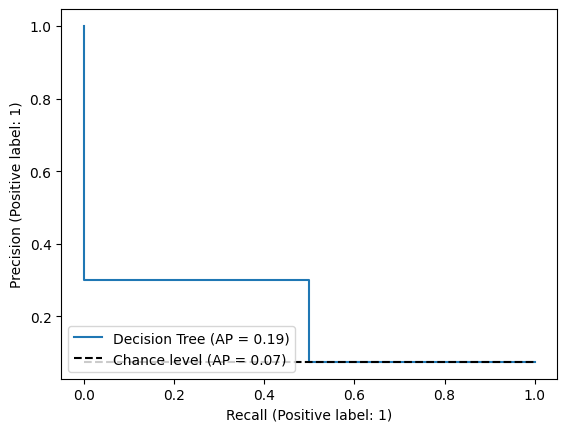

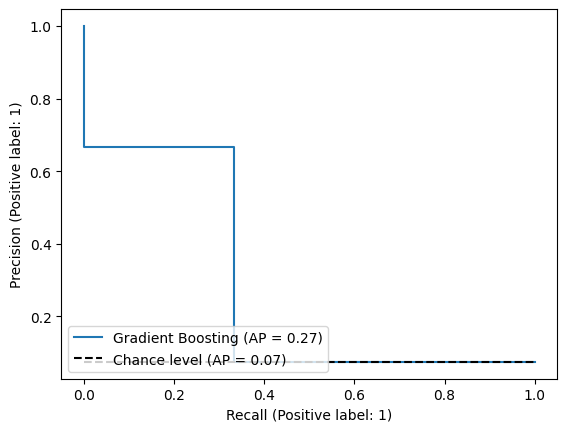

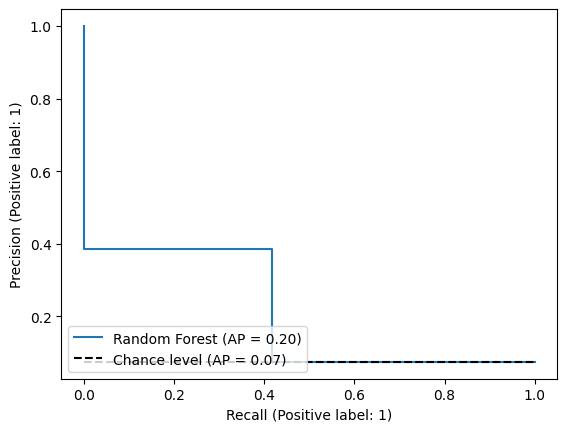

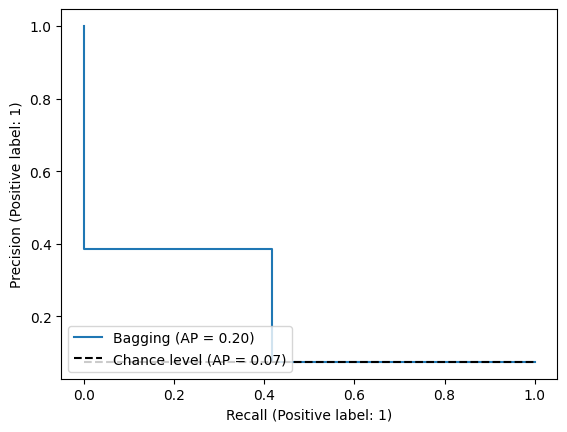

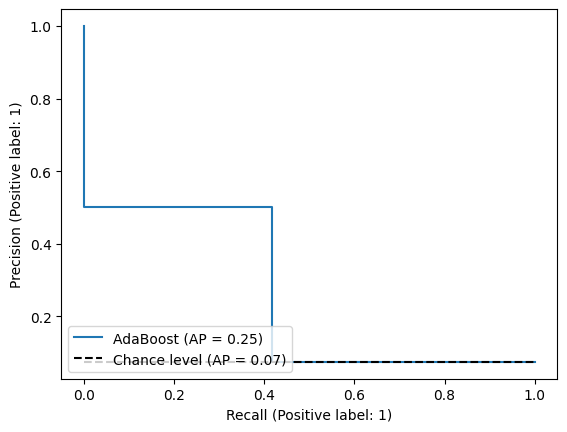

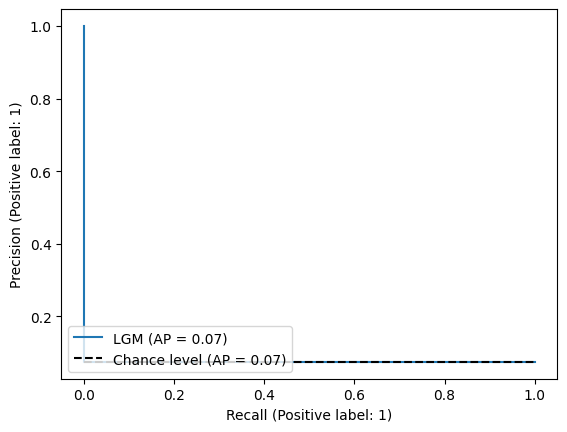

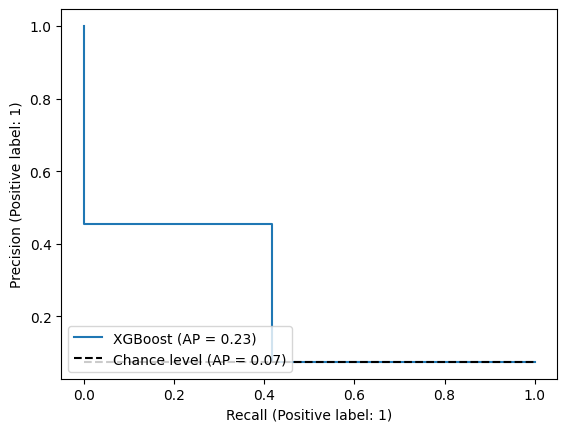

In [42]:
for current_model in models:
    predictions = models[current_model].predict(x_test)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    # Show the precision-recall curve
    display = PrecisionRecallDisplay.from_predictions(y_test,
                                                      predictions,
                                                      name = current_model,
                                                      plot_chance_level=True)

In [43]:
print('F1\tModel')
for current_model in models:
    # Calculate the F1 score for the model
    predictions = models[current_model].predict(x_test)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1Scores = f1_score(y_test,
                       predictions)
print('{:0.3f}\t{}'.format(f1Scores, current_model))

F1	Model
0.435	XGBoost


/home/conmec/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Extra Ideas

As you may have noticed, decision trees have a lot of hyperparameters (e.g. `max_depth`) that we can change. One of the advantages of decision trees is that, quite often, these don't need any tuning and work well straight out of the box. However, it is possible to perform hyperparamter tuning to find the best model possible. You could take a look at libraries such as [optuna](https://optuna.readthedocs.io/en/stable/) that do this for you. Just be careful you don't overfit!

Another advantage of decision trees is that they're highlhy interpretable - i.e., we can see which features are contributing most to the model's output. You could use a library such as [shap](https://github.com/shap/shap) to investigate which features are most important for your models.